In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from collections import OrderedDict
from datetime import datetime

import ads

from mpl_utils import mpl_style

plt.style.use(mpl_style)

%matplotlib inline

In [2]:
def query_trend(keywords, years, acknowledgements=False, filters=None,
                verbose=False):

    if isinstance(keywords, str):
        keywords = (keywords, )

    q_prefix = "ack:" if acknowledgements else ""
    filters = "" if filters is None else " ".join(filters)
    
    now = datetime.now()
    
    percents = []
    for year in tqdm.tqdm(years):
        
        modifier = f"year:{year} {filters}"
        all_papers = ads.SearchQuery(q=modifier)
        all_papers.execute()

        count = 0
        for keyword in keywords:
            papers = ads.SearchQuery(q=f"{q_prefix}\"{keyword}\" {modifier}")
            papers.execute()
            count += papers.response.numFound
        
        total = all_papers.response.numFound
        percent = 100 * count / float(total)

        if year == now.year:
            percent *= (365.0 / now.timetuple().tm_yday)
        
        percents.append(percent)
        
        if verbose:
            print(f"{year} '{keyword}' {count} / {total} ({percent:.2f}%)")

    return percents

In [3]:
languages = OrderedDict([
    ("IDL", ["IDL"]),
    ("Python", ["Python"]),
    ("Matlab", ["Matlab", "MATLAB"]),
    ("Wolfram", ["Wolfram", "Mathematica"])
])

years = np.arange(2000, 2019)

kwds = dict(years=years,
            acknowledgements=False,
            verbose=False,
            filters=("database:astronomy", "property:refereed"))

In [4]:
results = dict([(k, query_trend(v, **kwds)) for k, v in languages.items()])

100%|██████████| 19/19 [01:10<00:00,  3.74s/it]


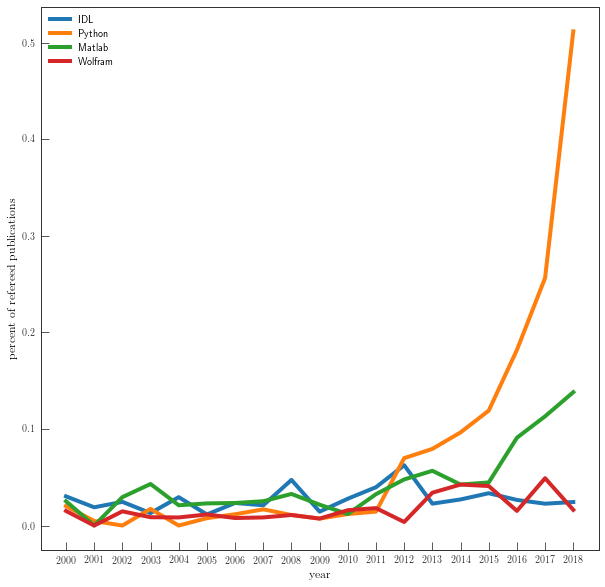

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
for key, percents in results.items():
    ax.plot(years, percents, "-", label=key, lw=4)

ax.set_xticks(years)

legend = plt.legend(frameon=False)

ax.set_ylabel(r"\textrm{percent of refereed publications}")
ax.set_xlabel(r"\textrm{year}")